In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pactus import Dataset, featurizers
from pactus.models import LSTMModel, RandomForestModel

from traj_xai.src import rdp_segmentation
from traj_xai.src import gaussian_perturbation
from traj_xai.src.xai import TrajectoryManipulator

In [4]:
def plot_trajectory_by_point_pair_and_coef(segments, coef):
    # Normalize coefficients for color mapping
    normalized_coefs = np.abs(coef).flatten() / np.max(np.abs(coef))
    colors = plt.cm.RdYlGn_r(normalized_coefs)  # Red to Green reversed colormap

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 7))

    # Plot each segment
    for i in range(len(segments)):
        # Convert Vector objects to numpy arrays
        temp = np.array([[p[0], p[1]] for p in segments[i]])  # Extract x, y from Vector

        if i < len(segments) - 1 and len(segments[i + 1]) > 0:
            next_point = np.array(
                [segments[i + 1][0][0], segments[i + 1][0][1]]
            ).reshape(1, 2)
            temp = np.concatenate((temp, next_point), axis=0)

        x_values = temp[:, 0]
        y_values = temp[:, 1]

        ax.plot(x_values, y_values, color=colors[i], linewidth=3)
        ax.scatter(x_values, y_values, c="blue", s=50)  # Add blue points

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array(normalized_coefs)
    fig.colorbar(sm, ax=ax, label="Normalized Importance")

    # Labels and title
    ax.set_title("Trajectory Explanation")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.grid(True)
    ax.set_aspect("equal")
    plt.show()


def explain_and_visualize_sample(
    dataset, segment_func, perturbation_func, model, sample_idx=0
):
    traj_points, label = dataset.trajs[sample_idx].r, dataset.labels[sample_idx]

    if traj_points is None or len(traj_points) == 0:
        print(f"Trajectory {sample_idx} is empty or None.")
        return

    manipulator = TrajectoryManipulator(
        traj_points, segment_func, perturbation_func, model
    )

    coef = manipulator.explain()
    if coef is None:
        print("No meaningful explanation (coef is None).")
        return

    coef = np.array(coef)
    print(f"Explanation coefficients: {coef}")
    if coef.ndim > 1:
        coef = np.mean(coef, axis=0)

    segments = manipulator.get_segment()
    print(f"Segments: {segments}")

    plot_trajectory_by_point_pair_and_coef(segments, coef)

In [6]:
dataset = Dataset.mnist_stroke()
train, test = dataset.split(0.8, random_state=42)
model = LSTMModel()
# Train the model on the train dataset
model.train(train, dataset, epochs=2, batch_size=64)
# Evaluate the model on a test dataset
evaluation = model.evaluate(test)

Epoch 1/2


c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


875/875 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.7451 - loss: 0.8422
Epoch 2/2
  1/875 ━━━━━━━━━━━━━━━━━━━━ 2:31 174ms/step - accuracy: 0.8125 - loss: 0.7531

c:\Users\nickz\miniconda3\envs\traj_xai\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


875/875 ━━━━━━━━━━━━━━━━━━━━ 100s 114ms/step - accuracy: 0.8966 - loss: 0.3552
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step


20:14:36 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


20:14:37 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
20:14:43 [INFO] Finished explanation process.


Explanation coefficients: [[ 0.61715094  0.7429094   0.64107317  0.44062243  0.14072982  0.14931131
   0.35477519  0.11870916  1.3788237  -0.14505111  0.89144815 -0.16932651
   0.59505392  0.65369347 -2.54617542  0.65601019 -1.90908677 -0.78630789
  -0.14784864 -0.75185992 -0.13015054 -0.44067017 -0.32515662 -1.75695772
  -0.54148662 -2.94699448  1.04806674  0.10534055]]
Segments: [[Vector([11.,  9.])], [Vector([12.,  9.]), Vector([13.,  9.])], [Vector([13.,  8.])], [Vector([14.,  8.]), Vector([15.,  8.]), Vector([16.,  8.]), Vector([17.,  8.])], [Vector([17.,  7.])], [Vector([18.,  7.]), Vector([19.,  7.]), Vector([20.,  7.]), Vector([21.,  7.])], [Vector([22.,  6.])], [Vector([18.,  9.])], [Vector([13., 10.])], [Vector([13., 11.]), Vector([13., 12.])], [Vector([14., 13.])], [Vector([14., 14.])], [Vector([15., 14.])], [Vector([16., 15.]), Vector([17., 16.])], [Vector([18., 16.])], [Vector([18., 17.])], [Vector([19., 18.])], [Vector([18., 19.])], [Vector([18., 20.])], [Vector([17., 20.

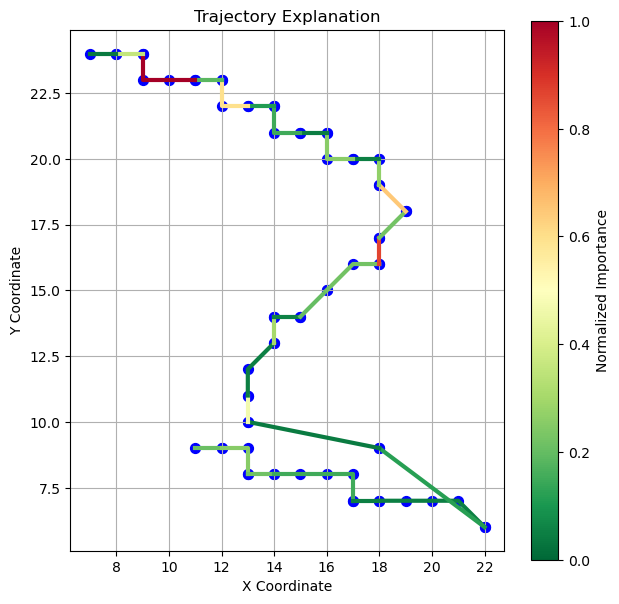

20:14:43 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


20:14:44 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
20:14:44 [WARNING] Only one class detected, skipping explanation.


No meaningful explanation (coef is None).


20:14:44 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


20:14:45 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
20:14:45 [WARNING] Only one class detected, skipping explanation.
20:14:45 [DEBUG] Starting explanation process...


No meaningful explanation (coef is None).
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


20:14:46 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
20:14:46 [WARNING] Only one class detected, skipping explanation.


No meaningful explanation (coef is None).


20:14:46 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


20:14:47 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
20:14:47 [WARNING] Only one class detected, skipping explanation.
20:14:47 [DEBUG] Starting explanation process...


No meaningful explanation (coef is None).
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


20:14:48 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
20:14:56 [INFO] Finished explanation process.


Explanation coefficients: [[-0.41848875 -0.44084564  0.12223293  0.42535705 -0.21741831 -0.39961122
  -0.12378597 -0.07248158 -0.27735519 -0.27136748 -0.44330449 -0.22790678
  -0.12817515 -0.45493133  0.40215362  0.02874759 -0.13727916  0.01159204
  -0.11197877 -0.25869027 -0.47321373  0.31351806  0.00662247 -0.14990145
   0.37079905  0.10544829  0.10656407  0.25990506  0.19422632 -0.13931556
   0.16803171 -0.40539312 -0.04773003 -0.23593227 -0.13167323 -0.03042337]
 [ 0.14572003  0.14704104  0.19972623 -0.16297225  0.17503763  0.13611659
   0.18059438  0.01766752 -0.05737032 -0.02080458  0.14870013  0.17850949
   0.17771679  0.15458609 -0.15202042 -0.01911949 -0.20919106  0.03490239
  -0.21963552 -0.02023757  0.15548966 -0.01801963 -0.01428994  0.18674559
  -0.13945044  0.21479763 -0.18591706  0.04768183 -0.18811073  0.18873818
  -0.18072155  0.13869679  0.00485112  0.17682068  0.17478225 -0.03688509]
 [ 0.27276873  0.29380461 -0.32195916 -0.2623848   0.04238068  0.26349463
  -0.05680

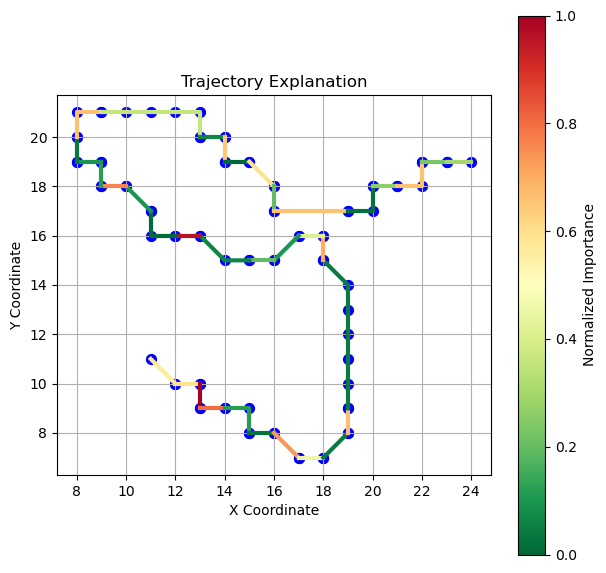

20:14:56 [DEBUG] Starting explanation process...


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


20:14:56 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(128, 10)
20:14:56 [INFO] Finished explanation process.


Explanation coefficients: [[ 0.0765392   3.87729716  0.00952467 -0.66060942 -0.13750924  0.0662168
   0.09088219]]
Segments: [[Vector([14.,  6.])], [Vector([14.,  7.]), Vector([14.,  8.]), Vector([14.,  9.]), Vector([14., 10.]), Vector([14., 11.])], [Vector([15., 12.])], [Vector([15., 13.]), Vector([15., 14.]), Vector([15., 15.]), Vector([15., 16.]), Vector([15., 17.]), Vector([15., 18.])], [Vector([16., 19.])], [Vector([16., 20.]), Vector([16., 21.])], [Vector([17., 22.])]]


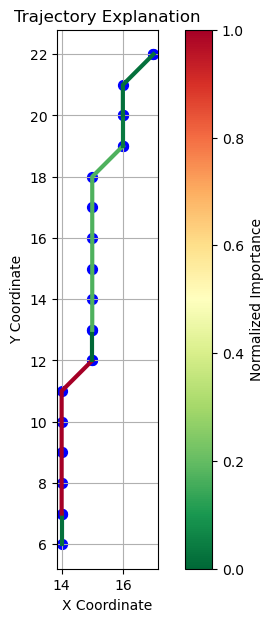

20:14:57 [DEBUG] Starting explanation process...


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


20:14:57 [DEBUG] Normalizing predictions: type=<class 'numpy.ndarray'>, shape=(1024, 10)
20:15:02 [INFO] Finished explanation process.


Explanation coefficients: [[-3.22433330e-01 -2.38774891e-01  1.19705683e-01  1.84427198e-01
   1.89334350e-01 -4.02912557e-01  3.15849067e-01 -2.78866958e-01
  -5.41399272e-01 -4.09592174e-01  2.46090339e-01  5.55960612e-01
  -7.82334704e-01 -5.35043225e-01]
 [ 2.54009798e-01 -9.99201108e-02  1.66448204e-02  2.42153901e-01
  -2.71956788e-01  1.58122945e-01 -1.08625279e-03  2.24395674e+00
   8.59958218e-01  1.19476333e+00 -2.32792958e+00 -6.64775413e-01
  -1.44172997e+00  8.72017925e-01]
 [ 6.84235326e-02  3.38695002e-01 -1.36350504e-01 -4.26581099e-01
   8.26224378e-02  2.44789613e-01 -3.14762814e-01 -1.96508978e+00
  -3.18558946e-01 -7.85171156e-01  2.08183924e+00  1.08814802e-01
   2.22406467e+00 -3.36974700e-01]]
Segments: [[Vector([12.,  8.])], [Vector([13.,  8.])], [Vector([14.,  7.])], [Vector([15.,  7.]), Vector([16.,  7.]), Vector([17.,  7.]), Vector([18.,  7.]), Vector([19.,  7.])], [Vector([20.,  8.])], [Vector([20.,  9.]), Vector([20., 10.]), Vector([20., 11.])], [Vector([19

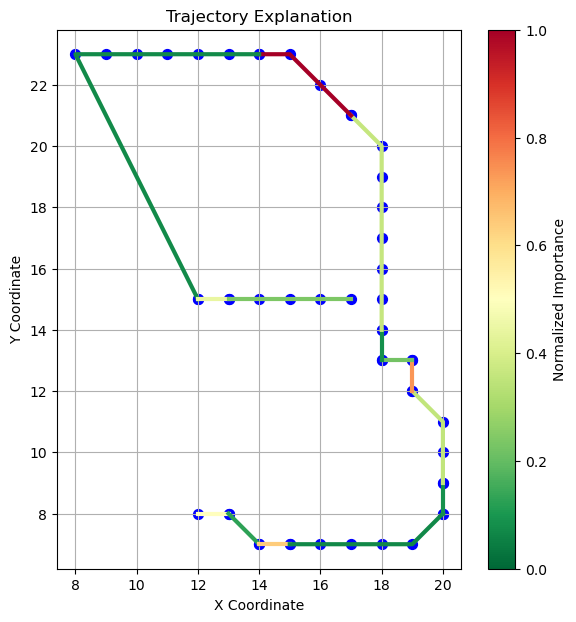

In [8]:
limit = 8  # float('inf')

for i in range(min(limit, len(train.trajs))):
    if train.trajs[i].r is None or len(train.trajs[i].r) == 0:
        print(f"Trajectory {i} is empty or None.")
        continue
    # Explain and visualize the first sample
    explain_and_visualize_sample(
        dataset,
        segment_func=rdp_segmentation,
        perturbation_func=gaussian_perturbation,
        model=model,
        sample_idx=i,
    )